In [2]:
import json
import os

import numpy as np
from matplotlib import pyplot as plt

from snn.layers import SCTNLayer
from snn.spiking_network import SpikingNetwork
from snn.spiking_neuron import create_SCTN, IDENTITY
from snn.resonator import test_resonator_on_chirp, freq_of_resonator, lp_by_lf



def neuron_output(neuron, signal_freq, shift_degrees=0, phase_number=20):
    y_events = neuron.out_spikes()
    samples_per_cycle =  clk_freq / signal_freq
    samples_per_degree = samples_per_cycle/360
    shift_samples = int(shift_degrees*samples_per_degree)
    y_events = y_events[
        (y_events > ((phase_number-1)/signal_freq) * clk_freq + shift_samples) &
        (y_events < ((phase_number/signal_freq) * clk_freq) + shift_samples)
    ]
    if len(y_events) == 0:
        return y_events
    # y_events -= int(((phase_number-1)/signal_freq) * clk_freq + shift_samples)
    return y_events

def events_to_spikes(events, run_window=0, spikes_arr_size=-1):
    if spikes_arr_size == -1:
        y_spikes = np.zeros(events[-1] + 1)
    else:
        y_spikes = np.zeros(spikes_arr_size)

    y_spikes[events] = 1
    if run_window == 0:
        return y_spikes

    y_spikes_rollsum = np.convolve(y_spikes, np.ones(run_window, dtype=int), 'valid')
    return y_spikes_rollsum

def amplify_spikes(base_spikes, spikes_window, base_min, base_max, amplify):
    base_spikes = events_to_spikes(base_spikes-resonator_input[0], spikes_arr_size=int(clk_freq/freq0)+1)
    result = np.zeros_like(base_spikes)
    result[np.arange(len(base_spikes)) % 2 == 1] = 1
    dc = (base_max + base_min)/2
    for i in range(spikes_window, len(result), spikes_window):
        slice_spikes = base_spikes[i:i+spikes_window]
        if len(slice_spikes) < spikes_window:
            break
        curr_spikes = np.sum(slice_spikes) - dc
        new_spikes = int(curr_spikes * amplify)

        if new_spikes > 0:
            spikes_ts = np.linspace(0, spikes_window, new_spikes).astype(int)//2*2 + i
            result[spikes_ts] = 1
        else:
            spikes_ts = np.linspace(0, spikes_window, abs(new_spikes)).astype(int)//2*2 - 1 + i
            result[spikes_ts] = 0
    result = np.where(result == 1)[0]
    return result

def smooth(arr, size):
    filter = np.exp(-(np.arange(size) - size//2)**2 / (2 * (size/4)**2))
    normalized_filter = filter / np.sum(filter)
    res = np.convolve(arr, normalized_filter, 'same')
    res[:size] = arr[:size]
    res[-size:] = arr[-size:]
    return res

def argmax(arr):
    return int(.5 * (np.argmax(arr) + len(arr) - np.argmax(arr[::-1]) - 1))

clk_freq = 1536000
# freq0 = 212
freq0 = 584
lf = 4

gain = 12
spikes_window = 500

best_lp = lp_by_lf(lf, freq0, clk_freq)
freq0 = freq_of_resonator(clk_freq, lf, best_lp)

duration = 25 / freq0
x = np.linspace(0, duration, int(duration * clk_freq))
t = x * 2 * np.pi * freq0
sine_wave = np.sin(t)

sine_wave2 = sine_wave[int(clk_freq/freq0*135/360):]
sine_wave = sine_wave[:len(sine_wave2)]

freq0

587.6490206469981

<string>:3: NumbaTypeSafetyWarning: unsafe cast from int64 to int32. Precision may be lost.


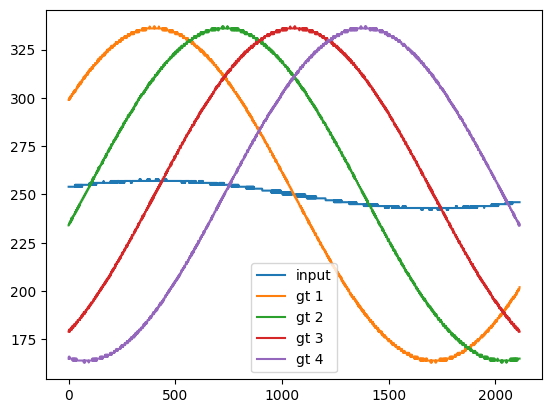

In [3]:
%matplotlib inline

resonator = SpikingNetwork(clk_freq)
resonator.add_amplitude(1000)
# Encode to pdm
neuron = create_SCTN()
neuron.activation_function = IDENTITY
resonator.add_layer(SCTNLayer([neuron]))

wave_length = int(clk_freq/freq0)
resonator.log_out_spikes(-1)
resonator.input_full_data(sine_wave)

resonator_input = neuron_output(resonator.neurons[0], freq0, shift_degrees=0)
rresonator_input = events_to_spikes(resonator_input-resonator_input[0], run_window=spikes_window, spikes_arr_size=int(clk_freq/freq0)+1)

ground_truth = []
phase_shifts = [0] + [45]*3
phase_shifts = np.cumsum(phase_shifts)

gt4stdp = []
for phase_shift_degree in phase_shifts:
    phase_shift = phase_shift_degree/360
    resonator.input_full_data(sine_wave[int((1-phase_shift)*wave_length):int((20-phase_shift)*wave_length)])
    resonator.log_out_spikes(-1)
    resonator.forget_logs()

    resonator.input_full_data(gain*sine_wave[int((1-phase_shift)*wave_length):])
    output = neuron_output(resonator.neurons[0], freq0, 0)
    ground_truth.append(output)

    output = neuron_output(resonator.neurons[0], freq0, phase_shift_degree + 45 - phase_shifts[0])
    half_wave = argmax(output[1:][(output[1:] - output[:-1])])
    output = output[:half_wave]
    gt4stdp.append(output)
    
gt1 = ground_truth[0]
gt2 = ground_truth[1]
gt3 = ground_truth[2]
gt4 = ground_truth[3]
rolling_gt = []
plt.plot(rresonator_input, label=f'input')
for i, gt in enumerate(ground_truth):
    rolling_gt.append(events_to_spikes(gt-resonator_input[0], run_window=spikes_window, spikes_arr_size=int(clk_freq/freq0)+1))
    plt.plot(rolling_gt[i], label=f'gt {i+1}')
    
gt_wave_amplitudes = [(o.max(), o.min()) for o in rolling_gt]
peaks = [argmax(rgt) for rgt in rolling_gt]
half_wave = [ground_truth[peak:peak+(wave_length//2)] for peak in peaks]
plt.legend()
plt.show()


In [4]:
def simple_resonator(
        freq0,
        clk_freq,
        lf,
        thetas,
        weights,
):
    LF = lf
    LP = lp_by_lf(LF, freq0, clk_freq)
    network = SpikingNetwork(clk_freq)
    network.add_amplitude(1000)

    # Encode to pdm
    neuron = create_SCTN()
    neuron.activation_function = IDENTITY
    network.add_layer(SCTNLayer([neuron]))

    # SCTN 1
    neuron = create_SCTN()
    neuron.synapses_weights = np.array([weights[0], -weights[1]], dtype=np.float64)
    neuron.leakage_factor = LF
    neuron.leakage_period = LP
    neuron.theta = thetas[0]
    neuron.activation_function = IDENTITY
    neuron.membrane_should_reset = False
    network.add_layer(SCTNLayer([neuron]))

    for i in range(3):
        neuron = create_SCTN()
        neuron.synapses_weights = np.array([weights[2+i]], dtype=np.float64)
        neuron.leakage_factor = LF
        neuron.leakage_period = LP
        neuron.theta = thetas[1+i]
        neuron.activation_function = IDENTITY
        neuron.membrane_should_reset = False
        network.add_layer(SCTNLayer([neuron]))

    # feedback
    network.connect_by_id(4, 1)
    return network

def learning_resonator(
        freq0,
        clk_freq,
        lf,
        thetas,
        weights,
        ground_truths,
        A,
        time_to_learn,
        max_weight,
        min_weight,
):
    network = simple_resonator(freq0, clk_freq, lf, thetas, weights)
    tau = network.clk_freq * time_to_learn / 2
    network.neurons[1].set_supervised_stdp(A, tau, clk_freq, max_weight, min_weight, ground_truths[0])
    for i in range(3):
        network.neurons[2+i].set_supervised_stdp(A, tau, clk_freq, max_weight, min_weight, ground_truths[1 + i])
    return network

def flat_weights(resonator):
    ws = []
    for neuron in resonator.neurons[1:]:
        for w in neuron.synapses_weights:
            ws.append(abs(float(f'{w:.3f}')))
    return np.array(ws)

def flat_thetas(resonator):
    return [float(f'{neuron.theta:.3f}') for neuron in resonator.neurons[1:]]

## Bias + Weights Learning

In [53]:

chosen_weights=np.array([147.352, 103.483, 113.441, 111.941, 114.235]) - 2
chosen_bias=np.array([-21.872, -56.648, -56.075, -57.154]) - 2

# chosen_weights=[67, 37, 41, 41, 41]
# chosen_bias=[-15,  -20.5, -20.5, -20.5]

# chosen_weights=np.array([147.352, 103.483, 113.441, 111.941, 114.235]) - 8
# chosen_bias=np.array([-21.872-4, -56.648-3, -56.075-2, -57.154-1]) + 5

In [54]:
resonator = learning_resonator(
    freq0=freq0,
    clk_freq=clk_freq,
    lf=lf,
    thetas=chosen_bias,
    weights=chosen_weights,
    ground_truths=ground_truth,
#     ground_truths=gt4stdp,
    A=1e-4,
    time_to_learn=1.1e-5,
    max_weight=np.inf,
    min_weight=-np.inf,
)
learning_rules = [neuron.supervised_stdp for neuron in resonator.neurons[1:]]
for i, neuron in enumerate(resonator.neurons):
    resonator.log_out_spikes(i)
    neuron.supervised_stdp = None

momentum_beta = .0

<IPython.core.display.Javascript object>


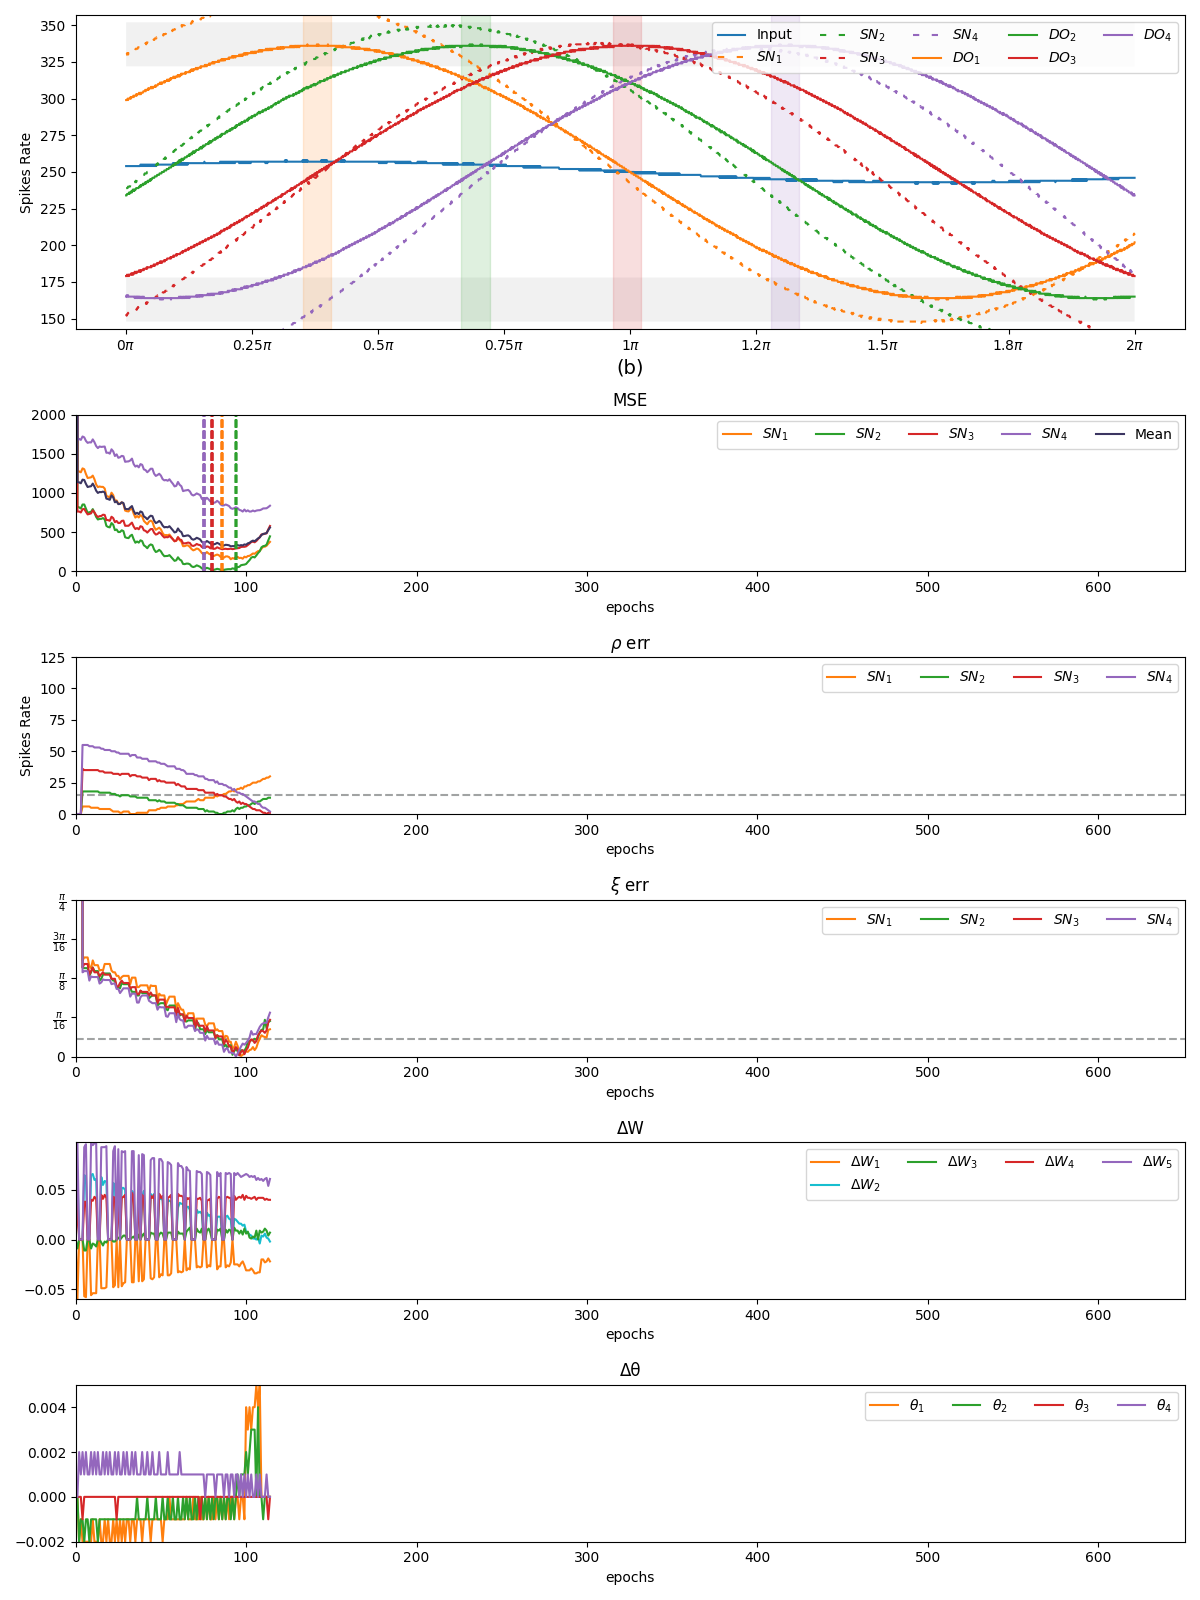

0it [00:00, ?it/s]C:\Users\User\AppData\Local\Temp\ipykernel_17764\1426489920.py:184: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  axs[bias_delta_axs].set_ylim(min_y, max_y)
114it [00:30,  3.72it/s, weights=[142.442, 104.188, 111.719, 113.277, 118.33], thetas=[-23.964, -58.716, -58.08, -59.021], mse=563, amplitudes=[(366.0, 147.0), (350.0, 134.0), (338.0, 132.0), (334.0, 109.0)], dc=[253.63356973995272, 256.0387706855792, 253.32245862884162, 242.05957446808512], tuned_parameters=0, xi=-8]       


KeyboardInterrupt: 

In [56]:
%matplotlib notebook
from tqdm import tqdm

from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# original colors
input_color = '#1f77b4'
mean_mse_color = '#3B3561'
y_eps_color = '#A1A3A3'
sns_th_color = '#A1A3A3'
colors = ['#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
# eeg colors
# colors = ['#50C9CE',  '#3B3561', '#EAD94C', '#51A3A3']
# def_color = '#F865B0'
epochs = 650

phase_axs = 0
mse_axs = 1
stdp_amplitude_axs = 2
stdp_tau_axs = 3
weights_delta_axs = 4
bias_delta_axs = 5

weights = np.zeros((epochs+1, 5))
prev_weights = np.array(flat_weights(resonator))

biases = np.zeros((epochs+1, 4))
prev_biases = np.array(flat_thetas(resonator))

mses = np.ones((epochs+1, 5)) * np.inf
mses[0, :4] = np.array([(gt**2).mean() for gt in ground_truth])
mses[0, 4] = mses[0, :4].mean()
min_mse = mses[0, 4]

stdp_amplitude = np.ones((epochs+1, 4)) * np.inf
stdp_amplitude[0, :] = np.array([lr.A for lr in learning_rules])

amplitude_ratio = np.zeros((epochs+1, 4))

stdp_tau = np.ones((epochs+1, 4)) * np.inf
stdp_tau[0, :] = np.array([lr.tau *1e6/clk_freq for lr in learning_rules])

phase_ratio = np.zeros((epochs+1, 4))

heights_ratios = np.ones(6)
heights_ratios[phase_axs] = 2
fig, axs = plt.subplots(6, 1, figsize=(12, 16), gridspec_kw={'height_ratios': heights_ratios})
axs[weights_delta_axs].set_title('ΔW')
axs[weights_delta_axs].set_xlim(0, epochs + 1)
axs[weights_delta_axs].set_xlabel('epochs')
# axs[weights_delta_axs].set_xticks([])
weights_lines = [axs[weights_delta_axs].plot([w], label=r'$ΔW_{i}$'.format(i=i+1), color=c)[0] for i, (c, w) in enumerate(zip([colors[0], '#17becf'] + colors[1:], weights[0]))]


axs[bias_delta_axs].set_title('Δθ')
axs[bias_delta_axs].set_xlim(0, epochs + 1)
axs[bias_delta_axs].set_xlabel('epochs')
# axs[bias_delta_axs].set_xticks([])
biases_lines = [axs[bias_delta_axs].plot([w], label=r'$θ_{i}$'.format(i=i+1), color=colors[i])[0] for i, w in enumerate(biases[0])]

y_epsilon = spikes_window * 0.03
x_epsilon = len(rresonator_input) * 5 / 360

gt_peaks = [argmax(gt) for gt in rolling_gt]
x_phase = np.linspace(0, 360, len(rresonator_input))
axs[phase_axs].set_ylabel('Spikes Rate')
axs[phase_axs].set_ylim(gt_wave_amplitudes[0][1] - spikes_window * 0.04, gt_wave_amplitudes[0][0] + spikes_window * 0.04)
x_ticks = np.arange(0, 361, 45)
axs[phase_axs].set_xticks(x_ticks)

# ax2 = axs[phase_axs].twinx()
# ax2.set_yticks([])
# ax2.set_ylabel('(c)', rotation='horizontal', fontsize=14)
axs[phase_axs].set_xlabel('(b)', fontsize=14)

x_labels_ticks = [r"$" + format(t/180, ".2g")+ r"\pi$" for t in x_ticks]
axs[phase_axs].set_xticklabels(x_labels_ticks)
        
axs[phase_axs].fill_between(x_phase, gt_wave_amplitudes[0][0] - y_epsilon, gt_wave_amplitudes[0][0] + y_epsilon, facecolor=y_eps_color, alpha=0.15)
axs[phase_axs].fill_between(x_phase, gt_wave_amplitudes[0][1] - y_epsilon, gt_wave_amplitudes[0][1] + y_epsilon, facecolor=y_eps_color, alpha=0.15)

axs[phase_axs].plot(x_phase, rresonator_input, label='Input', color=input_color)

phase_lines = [axs[phase_axs].plot(x_phase, gt, label=r'$SN_{i}$'.format(i=i+1), color=colors[i], linestyle='--', dashes=(3, 6))[0] for i, gt in enumerate(rolling_gt)]
[axs[phase_axs].plot(x_phase, gt, color=colors[i], alpha=1, label=r'$DO_{i}$'.format(i=i+1))[0] for i, gt in enumerate(rolling_gt)]
[axs[phase_axs].axvspan(x_phase[int(peak - x_epsilon)], x_phase[int(peak + x_epsilon)], alpha=0.15, color=colors[i]) for i, peak in enumerate(gt_peaks)]

axs[mse_axs].set_title('MSE')
axs[mse_axs].set_xlim(0, epochs+1)
axs[mse_axs].set_xlabel('epochs')
mse_lines = [axs[mse_axs].plot([mse], label=r'$SN_{i}$'.format(i=i+1) if i < 4 else 'Mean', color=color)[0]
             for i, (color, mse) in enumerate(zip(colors + [mean_mse_color], mses[0]))]

axs[stdp_amplitude_axs].set_title(r'$\rho$ err')
axs[stdp_amplitude_axs].set_xlim(0, epochs + 1)
axs[stdp_amplitude_axs].set_xlabel('epochs')
axs[stdp_amplitude_axs].set_ylabel('Spikes Rate')
axs[stdp_amplitude_axs].axhline(y_epsilon, color=sns_th_color, linestyle='--')
axs[stdp_amplitude_axs].set_ylim(0, 125)
stdp_amplitude_lines = [axs[stdp_amplitude_axs].plot([w], label=r'$SN_{i}$'.format(i=i+1), color=colors[i])[0] for i, w in enumerate(amplitude_ratio[0])]

# axs[stdp_tau_axs].set_title(r'$\tau$')
axs[stdp_tau_axs].set_title(r'$\xi$ err')
axs[stdp_tau_axs].set_xlim(0, epochs + 1)
axs[stdp_tau_axs].set_xlabel('epochs')
pr = 10/180 + x_epsilon / len(rresonator_input)
sns_th_line = ((1 + pr) / freq0)
# axs[stdp_tau_axs].axhline(sns_th_line, color=sns_th_color, linestyle='--')
axs[stdp_tau_axs].axhline(x_epsilon / len(rresonator_input) * 2*np.pi, color=sns_th_color, linestyle='--')
stdp_tau_lines = [axs[stdp_tau_axs].plot([w], label=r'$SN_{i}$'.format(i=i+1), color=colors[i])[0] for i, w in enumerate(stdp_tau[0])]
# axs[stdp_tau_axs].set_ylim(sns_th_line *.75, sns_th_line*2)
axs[stdp_tau_axs].set_ylim(0, np.pi/4)

y_ticks = np.arange(0, np.pi/4+0.001, np.pi/16)
axs[stdp_tau_axs].set_yticks(y_ticks)
y_labels_ticks = [r'$0$', r'$\frac{\pi}{16}$', r'$\frac{\pi}{8}$', r'$\frac{3\pi}{16}$', r'$\frac{\pi}{4}$']
axs[stdp_tau_axs].set_yticklabels(y_labels_ticks)

fig.tight_layout()

areas_sns = [[],[],[],[]] 
start_sns = [-1] * 4
momentum = [0] * 4
max_theta = -0.75
tuned_parameters = 0
count_after_tune = -1
with tqdm() as pbar:
    i = 1
    while count_after_tune != 0:
        count_after_tune -= 1
        run_with_stdp = True
        tuned_parameters = 0
        for neuron in resonator.neurons:
            neuron.membrane_potential = 0
            neuron.log_rand_gauss_var = 0
        resonator.forget_logs()
        resonator.input_full_data(sine_wave)

        # mse
        output = [events_to_spikes(neuron_output(neuron, freq0)-resonator_input[0],
                                   run_window=spikes_window,
                                   spikes_arr_size=int(clk_freq/freq0)+1)
                  for neuron in resonator.neurons[1:]]
        max_mse_y = 0
        mses[i, :4] = [((gt - o)**2).mean() for gt, o in zip(rolling_gt, output)]
        mses[i, 4] = mses[i, :4].mean()
        if mses[i, 4] < min_mse:
            min_mse = mses[i, 4]
            run_with_stdp = False
        for j, line in enumerate(mse_lines):
            line.set_xdata(np.arange(i))
            line.set_ydata(mses[:i, j])
            max_mse_y = np.max([max_mse_y, 1.5*mses[max(0, i-4):i+1, j].max()])
            
#         axs[mse_axs].set_ylim(0, max_mse_y)
        axs[mse_axs].set_ylim(0, 2000)
        for j, sns in enumerate(start_sns):
            if sns != -1:
                axs[mse_axs].axvline(sns, color=colors[j], linestyle='--')

        # weights chart
        weights[i, :] = np.array(flat_weights(resonator)) - prev_weights
        prev_weights = np.array(flat_weights(resonator))
        for j, line in enumerate(weights_lines):
            line.set_xdata(np.arange(i))
            line.set_ydata(weights[:i, j])
        max_y = weights[:i+1, :].max()
        min_y = weights[:i+1, :].min()
        axs[weights_delta_axs].set_ylim(min_y, max_y)

        # phase chart
        for j, o in enumerate(output):
            phase_lines[j].set_ydata(o)

        # biases chart
        biases[i, :] = np.array(flat_thetas(resonator)) - prev_biases
        prev_biases = np.array(flat_thetas(resonator))
        for j, line in enumerate(biases_lines):
            line.set_xdata(np.arange(i))
            line.set_ydata(biases[:i, j])
        max_y = biases[:i+1, :].max()
        min_y = biases[:i+1, :].min()
        axs[bias_delta_axs].set_ylim(min_y, max_y)

        # stdp charts:
        # replace with
        # for j, lr in enumerate(learning_rules):
        #     stdp_amplitude[i, j] = lr.A
        #     stdp_tau[i, j] = lr.tau

        thetas_shift = [-.2*(((2*np.mean(o) - spikes_window)/spikes_window)**2)*np.sign(np.mean(o)-spikes_window/2) for o in output]
        for j, neuron in enumerate(resonator.neurons[1:]):
            bs = thetas_shift[j]
            momentum[j] = bs + momentum_beta * momentum[j]
            neuron.theta += momentum[j]
            if neuron.theta > max_theta:
                neuron.theta = max_theta

        peaks = [argmax(o)for o in output]
        # activate weights learning
        for j, o in enumerate(output):
            dc = o.mean()
            o_max = o.max()
            o_min = o.min()
            neuron = resonator.neurons[1+j]
            # first 2 conditions to check if the amplitude is on the right place.
            # next condition is to check if the peak is in the right place.
            o_argmax = argmax(o)

            stdp_amplitude[i, j] = abs(o_max - gt_wave_amplitudes[j][0])
            stdp_tau[i, j] = abs(o_argmax - gt_peaks[j]) / len(rresonator_input) * 2*np.pi
            if (
                abs(o_argmax - gt_peaks[j]) <= x_epsilon and
                abs(o_max - gt_wave_amplitudes[j][0]) > y_epsilon/4 and
                abs(o_min - gt_wave_amplitudes[j][1]) > y_epsilon/4
            
#             if ((j == 0 and i >= 136) or
#                 (j == 1 and i >= 221) or
#                 (j == 2 and i >= 300 ) or
#                 (j == 3 and i >= 60)
               ):
                if start_sns[j] == -1:
                    start_sns[j] = i
                areas_j = areas_sns[j]
                if areas_j == [] or len(areas_j[-1]) == 2:
                    areas_j.append((i, ))
                # 100 mse -> stretch_or_shrink_scale 0.001
                stretch_or_shrink_scale = (mses[i, j]*1000//1e4) / 1e4
                if gt_wave_amplitudes[j][1] < o_min < o_max < gt_wave_amplitudes[j][0]:
                    neuron.theta -= stretch_or_shrink_scale
                    neuron.synapses_weights[0] += 2 * stretch_or_shrink_scale #/ len(neuron.synapses_weights)
                    if j == 0:
                        neuron.synapses_weights[1] -= 2 * stretch_or_shrink_scale  # / len(neuron.synapses_weights)
                elif o_min < gt_wave_amplitudes[j][1] < gt_wave_amplitudes[j][0] < o_max:
                    stretch_or_shrink_scale *= 2
                    neuron.theta += stretch_or_shrink_scale
                    neuron.synapses_weights[0] -= 2 * stretch_or_shrink_scale #/ len(neuron.synapses_weights)
                    if j == 0:
                        neuron.synapses_weights[1] += 2 * stretch_or_shrink_scale  # / len(neuron.synapses_weights)
            else:
                areas_j = areas_sns[j]
                if areas_j != [] and len(areas_j[-1]) == 1:
                    areas_j[-1] = (areas_j[-1][0], i)
            if abs(o_argmax - gt_peaks[j]) <= x_epsilon:
                tuned_parameters += 1
            if (abs(o_max - gt_wave_amplitudes[j][0]) <= y_epsilon and
                abs(o_min - gt_wave_amplitudes[j][1]) <= y_epsilon
            ):
                tuned_parameters += 1
            if not run_with_stdp:
                neuron.supervised_stdp = None
                stdp_amplitude[i, j] = stdp_amplitude[i-1, j]
                stdp_tau[i, j] = stdp_tau[i-1, j]
                amplitude_ratio[i, j] = amplitude_ratio[i-1, j]
                phase_ratio[i, j] = phase_ratio[i-1, j]
            else:
                wave_amplitude = o_max - o_min
                gt_wave_amplitude = gt_wave_amplitudes[j][0] - gt_wave_amplitudes[j][1]
                wave_amplitude_ratio = abs((wave_amplitude - gt_wave_amplitude)/gt_wave_amplitude)        # number between 0 - 1 represent [0 - gt_wave_amplitude]
#                 phase_diff_ratio = abs(peaks[j] - gt_peaks[j]) / len(o)                                   # number between 0 - 1 represent [0 - 180]
                phase_diff_ratio = 10/180 + abs(peaks[j] - gt_peaks[j]) / len(o)                                   # number between 0 - 1 represent [0 - 180]
                
                neuron.supervised_stdp = learning_rules[j]
                neuron.supervised_stdp.A = (1 + wave_amplitude_ratio) * 10e-5
#                 phase_diff_ratio = abs(peaks[j] - gt_peaks[j]) / len(o)                                   # number between 0 - 1 represent [0 - 180]
#                 neuron.supervised_stdp.tau = 1 * 1e-3 * clk_freq / 2 / freq0 * (1 + phase_diff_ratio)       # number between 0 - 1 represent [0 - 180]
                neuron.supervised_stdp.tau = clk_freq / freq0 * (phase_diff_ratio)
                
                amplitude_ratio[i, j] = wave_amplitude_ratio
                stdp_amplitude_lines[j].set_xdata(np.arange(i))
                stdp_amplitude_lines[j].set_ydata(stdp_amplitude[:i, j])
                
                phase_ratio[i, j] = phase_diff_ratio
                
            stdp_tau_lines[j].set_xdata(np.arange(i))
            # stdp_tau_lines[j].set_ydata(stdp_tau[:i, j] * 1e6 / clk_freq)
            stdp_tau_lines[j].set_ydata(stdp_tau[:i, j])

#         if i > 10:
            # axs[stdp_amplitude_axs].set_ylim(stdp_amplitude[10:i, :].min() * .93, stdp_amplitude[10:i, :].max() * 1.07)
            # axs[stdp_tau_axs].set_ylim(stdp_tau[10:i, :].min() * .93 * 1e6 / clk_freq, stdp_tau[10:i, :].max() * 1.07 * 1e6 / clk_freq)
#             axs[stdp_amplitude_axs].set_ylim(stdp_amplitude[:i, :].min(), stdp_amplitude[:i, :].max())
#             axs[stdp_tau_axs].set_ylim(stdp_tau[:i, :].min(), stdp_tau[:i, :].max())

        wave_amplitudes = [(o.max(), o.min()) for o in output]
        
        x = np.linspace(0, 360, len(rresonator_input))
        xi = x[int(argmax(output[0]))] - x[int(argmax(rresonator_input))]
        pbar.set_postfix({'weights': flat_weights(resonator).tolist(), 'thetas': flat_thetas(resonator), 'mse': mses[i, :].mean(),
                          'amplitudes': wave_amplitudes, 'dc': [o.mean() for o in output], 'tuned_parameters': tuned_parameters, 'xi': xi})

        for j in range(6):
            axs[j].legend(loc='upper right',  ncol=5 if j < 4 else 4)

        fig.canvas.draw()
        fig.canvas.flush_events()

        pbar.update(1)
        i += 1
        if i == epochs:
            min_mse = np.argmin(mses[:i-1].mean(axis=1))
            # min_mse = i-1
            print(f'min mse {mses[min_mse].mean()}')
            chosen_bias = biases[min_mse]
            chosen_weights = weights[min_mse]
            print(f'chosen_bias={chosen_bias.tolist()}')
            print(f'chosen_weights={chosen_weights.tolist()}')
            x = np.linspace(0, 360, len(rresonator_input))
            print(f'xi = {x[int(argmax(output[0]))] - x[int(argmax(rresonator_input))]}')
            i = 1
            
        
        if tuned_parameters == 8 and count_after_tune < 0:
            count_after_tune = 1
            print('tune')
            print('weights', list(weights[i-1]))
            print('thetas', list(biases[i-1]))
            print('mse', list(mses[i-1]))
            
for j, areas in enumerate(areas_sns):
    for area in areas:
        a0 = area[0]
        a1 = i
        if len(area) == 2:
            a1 = area[1]
        axs[mse_axs].fill_between(np.arange(a0, a1), 0, 2000, facecolor=colors[j], alpha=0.15)

fig.tight_layout()

In [48]:
chosen_weights=[67, 37, 41, 41, 41]
chosen_bias=[-15,  -20.5, -20.5, -20.5]

[-14.99  -20.564 -20.667 -20.602]
[67.028 37.154 41.103 41.304 41.192]


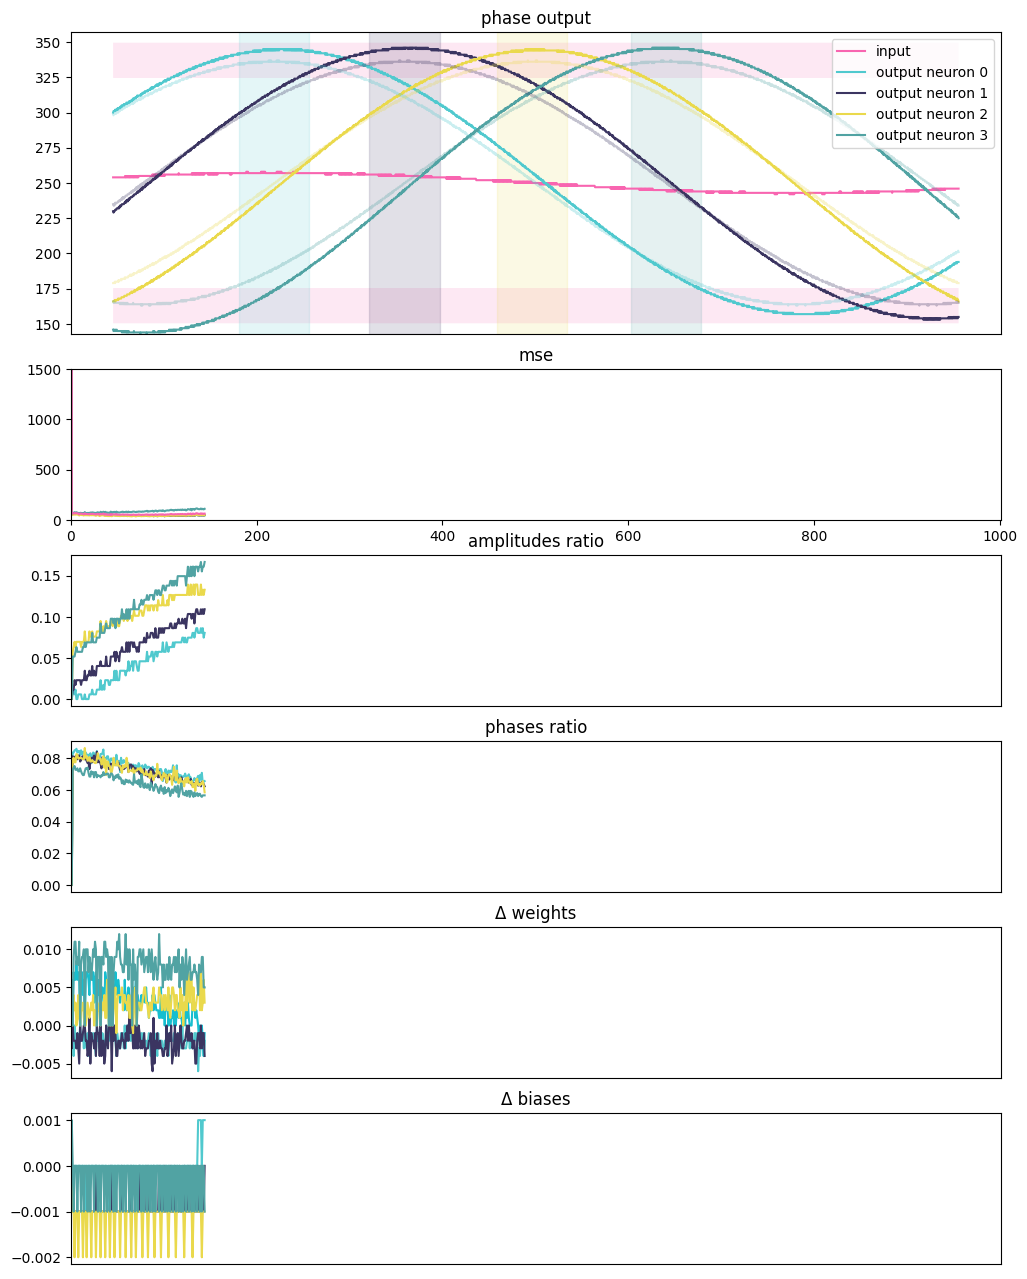

In [408]:
%matplotlib inline
colors = ['#50C9CE',  '#3B3561', '#EAD94C', '#51A3A3']
def_color = '#F865B0'
fig, axs = plt.subplots(6, 1, figsize=(12, 16), gridspec_kw={'height_ratios': heights_ratios})
axs[weights_delta_axs].set_title('Δ weights')
axs[weights_delta_axs].set_xlim(0, epochs + 1)
axs[weights_delta_axs].set_xticks([])
weights_lines = [axs[weights_delta_axs].plot(weights[:i, j], label=f'weight {j}', color=c)[0] for j, c in enumerate([colors[0], '#17becf'] + colors[1:])]


axs[bias_delta_axs].set_title('Δ biases')
axs[bias_delta_axs].set_xlim(0, epochs + 1)
axs[bias_delta_axs].set_xticks([])
biases_lines = [axs[bias_delta_axs].plot(biases[:i, j], label=f'bias {j}', color=c)[0] for j, c in enumerate(colors)]

y_epsilon = spikes_window * 0.025
x_epsilon = len(rresonator_input) * 15 / 360

gt_peaks = [argmax(gt) for gt in rolling_gt]
x_phase = np.arange(0, len(rresonator_input))
axs[phase_axs].set_title('phase output')
axs[phase_axs].set_ylim(gt_wave_amplitudes[0][1] - spikes_window * 0.04, gt_wave_amplitudes[0][0] + spikes_window * 0.04)
axs[phase_axs].set_xticks([])
axs[phase_axs].fill_between(x_phase, gt_wave_amplitudes[0][0] - y_epsilon, gt_wave_amplitudes[0][0] + y_epsilon, facecolor=def_color, alpha=0.15)
axs[phase_axs].fill_between(x_phase, gt_wave_amplitudes[0][1] - y_epsilon, gt_wave_amplitudes[0][1] + y_epsilon, facecolor=def_color, alpha=0.15)

axs[phase_axs].plot(rresonator_input, label='input', color=def_color)
phase_lines = [axs[phase_axs].plot(o, label=f'output neuron {i}', color=colors[i])[0] for i, o in enumerate(output)]
[axs[phase_axs].plot(gt, color=colors[i], alpha=.3)[0] for i, gt in enumerate(rolling_gt)]
[axs[phase_axs].axvspan(peak - x_epsilon, peak + x_epsilon, alpha=0.15, color=colors[i]) for i, peak in enumerate(gt_peaks)]

axs[mse_axs].set_title('mse')
axs[mse_axs].set_xlim(0, epochs+1)
axs[mse_axs].set_ylim(0, 1500)
mse_lines = [axs[mse_axs].plot(mses[:i, j], label=f'mse {j}' if j < 4 else 'mean mse', color=color)[0]
             for j, color in enumerate(colors + [def_color])]

# [axs[mse_axs].fill_between(np.arange(sns[0][0], i), 0, 1500, facecolor=c, alpha=0.15) for c, sns in zip(colors, areas_sns)] 
# [axs[mse_axs].axvline(sns[0][0], color=c, linestyle='--') for c, sns in zip(colors, areas_sns)]

axs[stdp_amplitude_axs].set_title('amplitudes ratio')
axs[stdp_amplitude_axs].set_xlim(0, epochs + 1)
axs[stdp_amplitude_axs].set_xticks([])
stdp_amplitude_lines = [axs[stdp_amplitude_axs].plot(amplitude_ratio[:i, j], label=f'neuron {j}', color=c)[0] for j, c in enumerate(colors)]

axs[stdp_tau_axs].set_title('phases ratio')
axs[stdp_tau_axs].set_xlim(0, epochs + 1)
axs[stdp_tau_axs].set_xticks([])
stdp_tau_lines = [axs[stdp_tau_axs].plot(phase_ratio[:i, j], label=f'neuron {j}', color=c)[0] for j, c in enumerate(colors)]
axs[phase_axs].legend(loc='upper right')

In [345]:
mses

array([[2.58293084e+09, 2.58729690e+09, 2.59832360e+09, 2.60927009e+09,
        2.59445536e+09],
       [1.85794421e+03, 1.04210922e+03, 9.17969740e+02, 2.56676832e+03,
        1.59619787e+03],
       [1.86151773e+03, 1.04221560e+03, 9.18082742e+02, 2.56944634e+03,
        1.59781560e+03],
       ...,
       [           inf,            inf,            inf,            inf,
                   inf],
       [           inf,            inf,            inf,            inf,
                   inf],
       [           inf,            inf,            inf,            inf,
                   inf]])

In [31]:
min_mse = np.argmin(mses[:i-1].mean(axis=1))
# min_mse = i-1
print(f'min mse {mses[min_mse].mean()}')
chosen_bias = flat_thetas(resonator)
chosen_weights = flat_weights(resonator)

print(f'chosen_bias={chosen_bias}')
print(f'chosen_weights={chosen_weights}')

min mse 102.7503623188406
chosen_bias=[-38.576, -29.943, -28.106, -27.831]
chosen_weights=[123.81   48.212  59.177  56.132  55.85 ]


In [130]:
w0 = 36

# chosen_bias=[-22] + [-58.75]*3
# chosen_weights=[137, 93] + [117.5]*3

chosen_bias=[9.896/2, -21.483, -20.349, -20.591]
chosen_weights=[34.091/2, 53.846/2, 42.951, 40.759, 41.223]

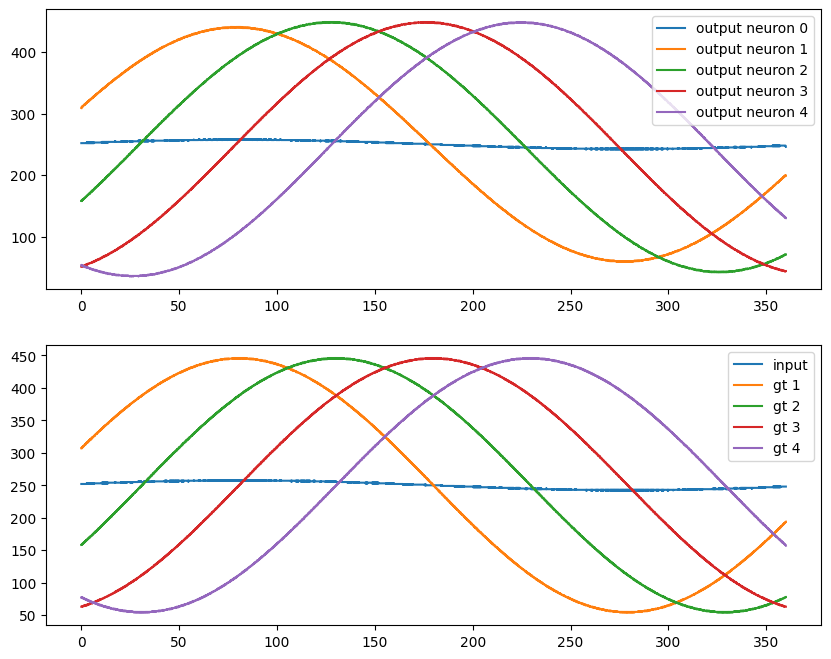

In [32]:
%matplotlib inline
res_resonator = simple_resonator(
    clk_freq=clk_freq,
    freq0=freq0,
    lf=lf,
    thetas=chosen_bias,
    weights=chosen_weights,
)

for i in range(len(res_resonator.neurons)):
    res_resonator.log_out_spikes(i)
res_resonator.input_full_data(sine_wave)

output = [events_to_spikes(neuron_output(neuron, freq0)-resonator_input[0],
                           run_window=spikes_window,
                           spikes_arr_size=int(clk_freq/freq0)+3)
          for neuron in res_resonator.neurons]

fig, axs = plt.subplots(2, 1, figsize=(10, 8))
for i, o in enumerate(output):
    x = np.linspace(0, 360, len(o))
    axs[0].plot(x, o, label=f'output neuron {i}')
axs[0].legend()
inp = events_to_spikes(resonator_input-resonator_input[0], run_window=spikes_window)
x = np.linspace(0, 360, len(inp))
axs[1].plot(x, inp, label=f'input')
for i, gt in enumerate(rolling_gt):
    x = np.linspace(0, 360, len(gt))
    axs[1].plot(x, gt, label=f'gt {i+1}')

axs[1].legend()

x = np.linspace(0, 360, len(rresonator_input))
xi = x[int(argmax(output[0]))] - x[int(argmax(rresonator_input))]

(441.0, 59.0)
(448.0, 43.0)
(447.0, 40.0)
(446.0, 38.0)
# 288.28065163815006 ~ peak 293.702 nid 4 snr 12.217 pdr: 0.000 msnr: 1.843
xi = -0.5961498654522899
chosen_bias=[-38.576, -29.943, -28.106, -27.831]
chosen_weights=[123.81, 48.212, 59.177, 56.132, 55.85]
amplitude 204.0
dc 242.01794763670893
f0 = 294.048
f0/2 = 344.009


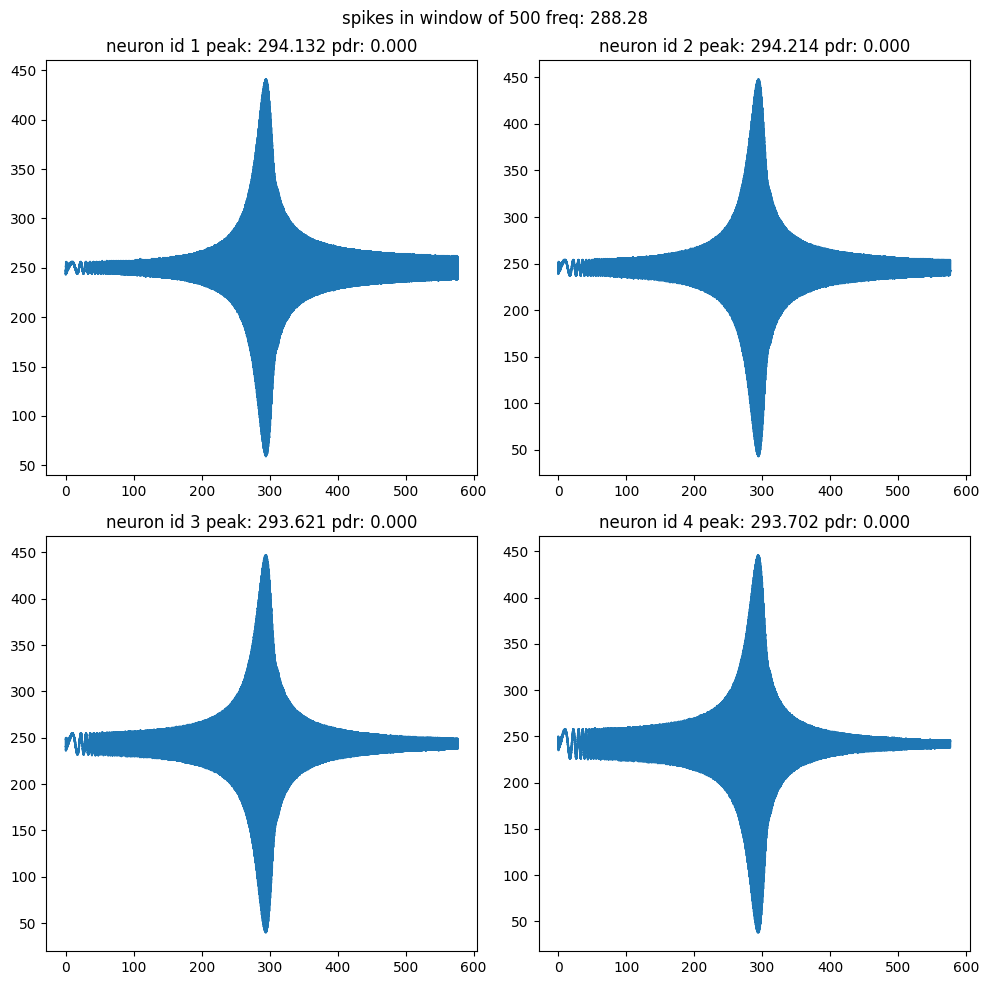

In [33]:
%matplotlib inline
x = np.linspace(0, 360, len(output[0]))
xi = x[int(argmax(output[1]))] - x[int(argmax(output[0]))]
                                            
from snn.resonator import test_resonator_on_chirp, freq_of_resonator
clk_freq = 1_536_000
res_resonator = simple_resonator(
    clk_freq=clk_freq,
    freq0=freq0,
    lf=lf,
    thetas=chosen_bias,
    weights=chosen_weights,
#     thetas=[-9.896, -21.483, -20.349, -20.591],
#     weights=[53.846, 34.091, 42.951, 40.759, 41.223]
)

for nid in range(1, 5):
    res_resonator.log_out_spikes(nid)

start_freq = 0
spectrum = 2 * freq0
res_resonator.forget_logs()

step = 200/(clk_freq)
test_size = int(spectrum / step)
test_resonator_on_chirp(
    res_resonator,
    start_freq=start_freq,
    step=step,
    test_size=test_size,
    clk_freq=clk_freq
)

snr = [0] * 4
pdr = [0] * 4
peak = [0] * 4
best_lp = lp_by_lf(lf, freq0, clk_freq)
f_resonator = freq_of_resonator(clk_freq, lf, best_lp)
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle(f'spikes in window of {spikes_window} freq: {f_resonator:.2f}')
for nid in range(4):
    spikes_neuron = res_resonator.neurons[nid + 1]
    y_events = spikes_neuron.out_spikes()
    y_spikes = np.zeros(test_size)
    y_spikes[y_events] = 1
    y_spikes = np.convolve(y_spikes, np.ones(spikes_window, dtype=int), 'valid')
    x = np.linspace(start_freq, start_freq+spectrum, len(y_spikes))

    ax = axs[nid//2, nid%2]
    # ax.set_ylim(spikes_window/4, 3*spikes_window/4)
    ax.plot(x, y_spikes)
    snr[nid] = (y_spikes.max() - y_spikes.min())/y_spikes.std()
    std = y_spikes.std()
    print((np.max(y_spikes), np.min(y_spikes)))
#     p = y_spikes[((x > freq0 - 1*std) & (x < freq0 + 1*std))].max()
#     n = y_spikes[((x < freq0 - 2*std) | (x > freq0 + 2*std))].max()
#     pdr[nid] = p / n
    pdr[nid] = 0
    peak[nid] = x[np.argmax(y_spikes)]
    ax.set_title(f'neuron id {nid + 1} peak: {peak[nid]:.3f} pdr: {pdr[nid]:.3f}')
fig.tight_layout()

# nid = np.argmax(np.array(snr) / np.abs(np.array(peak) - freq0))
nid = 3
msnr = y_spikes.max() / y_spikes.mean()
print(f'# {freq0} ~ peak {peak[nid]:.3f} nid {nid+1} snr {snr[nid]:.3f} pdr: {pdr[nid]:.3f} msnr: {msnr:.3f}')
print(f'xi = {xi}')
print(f'chosen_bias={list(chosen_bias)}')
print(f'chosen_weights={list(chosen_weights)}')

f0 = x[y_spikes == y_spikes.max()]
f0 = (f0[0] + f0[-1])/2
f2 = np.mean(y_spikes) + .5*(np.max(y_spikes) - np.mean(y_spikes))
arg_Q = x[(y_spikes > f2*.997) & (y_spikes < f2*1.003)]
print(f'amplitude {(np.max(y_spikes) - np.min(y_spikes))/2}')
print(f'dc {np.mean(y_spikes)}')
print(f'f0 = {f0:.3f}')
print(f'f0/2 = {f2:.3f}')
# print(f'Q factor {f0/(arg_Q[-1] - arg_Q[0]):.3f}, f1 = {arg_Q[0]:.3f}, f2 = {arg_Q[-1]:.3f}')

In [327]:
%matplotlib inline
from snn.resonator import test_resonator_on_chirp, freq_of_resonator

for w0 in range(18, 45):

    print('==========')
    chosen_bias=[-w0, -20.5, -20.5, -20.5]
    chosen_weights=[4*w0, 2*w0, 41.0, 41.0, 41.0]
    
    res_resonator = simple_resonator(
        clk_freq=clk_freq,
        freq0=freq0,
        lf=lf,
        thetas=chosen_bias,
        weights=chosen_weights,
    )

    for i in range(len(res_resonator.neurons)):
        res_resonator.log_out_spikes(i)
    res_resonator.input_full_data(sine_wave)

    output = [events_to_spikes(neuron_output(neuron, freq0)-resonator_input[0],
                               run_window=spikes_window,
                               spikes_arr_size=int(clk_freq/freq0)+3)
              for neuron in res_resonator.neurons]

    x = np.linspace(0, 360, len(rresonator_input))
    xi = x[int(argmax(output[1]))] - x[int(argmax(rresonator_input))]

    clk_freq = 1_536_000
    res_resonator = simple_resonator(
        clk_freq=clk_freq,
        freq0=freq0,
        lf=lf,
        thetas=chosen_bias,
        weights=chosen_weights,
    )

    for nid in range(1, 5):
        res_resonator.log_out_spikes(nid)

    start_freq = 0
    spectrum = 2 * freq0
    res_resonator.forget_logs()

    step = 200/(clk_freq)
    test_size = int(spectrum / step)
    test_resonator_on_chirp(
        res_resonator,
        start_freq=start_freq,
        step=step,
        test_size=test_size,
        clk_freq=clk_freq
    )

    best_lp = lp_by_lf(lf, freq0, clk_freq)
    f_resonator = freq_of_resonator(clk_freq, lf, best_lp)
    spikes_neuron = res_resonator.neurons[-1]
    y_events = spikes_neuron.out_spikes()
    y_spikes = np.zeros(test_size)
    y_spikes[y_events] = 1
    y_spikes = np.convolve(y_spikes, np.ones(spikes_window, dtype=int), 'valid')
    x = np.linspace(start_freq, start_freq+spectrum, len(y_spikes))

    print((np.max(y_spikes), np.min(y_spikes)))

    # nid = np.argmax(np.array(snr) / np.abs(np.array(peak) - freq0))
    msnr = y_spikes.max() / y_spikes.mean()
    print(f'# {freq0}')
    print(f'xi = {xi}')
    print(f'w0 = {w0}')
    print(f'chosen_bias={list(chosen_bias)}')
    print(f'chosen_weights={list(chosen_weights)}')

    f0 = x[y_spikes == y_spikes.max()]
    f0 = (f0[0] + f0[-1])/2
    f2 = np.mean(y_spikes) + .5*(np.max(y_spikes) - np.mean(y_spikes))
    arg_Q = x[(y_spikes > f2*.997) & (y_spikes < f2*1.003)]
    print(f'amplitude {(np.max(y_spikes) - np.min(y_spikes))/2}')
    print(f'dc {np.mean(y_spikes)}')
    print(f'f0 = {f0:.3f}')
    print(f'f0/2 = {f2:.3f}')
    print(f'Q factor {f0/(arg_Q[-1] - arg_Q[0]):.3f}, f1 = {arg_Q[0]:.3f}, f2 = {arg_Q[-1]:.3f}')

(332.0, 167.0)
# 212.2065907891938
xi = 15.491912746698318
w0 = 18
chosen_bias=[-18, -20.5, -20.5, -20.5]
chosen_weights=[72, 36, 41.0, 41.0, 41.0]
amplitude 82.5
dc 250.13016593464118
f0 = 213.189
f0/2 = 291.065
Q factor 4.579, f1 = 184.821, f2 = 231.376
(357.0, 143.0)
# 212.2065907891938
xi = 1.6026116634515546
w0 = 19
chosen_bias=[-19, -20.5, -20.5, -20.5]
chosen_weights=[76, 38, 41.0, 41.0, 41.0]
amplitude 107.0
dc 250.1326016556029
f0 = 217.397
f0/2 = 303.566
Q factor 6.005, f1 = 194.320, f2 = 230.522
(396.0, 104.0)
# 212.2065907891938
xi = -19.872384626799224
w0 = 20
chosen_bias=[-20, -20.5, -20.5, -20.5]
chosen_weights=[80, 40, 41.0, 41.0, 41.0]
amplitude 146.0
dc 250.13265627368446
f0 = 221.521
f0/2 = 323.066
Q factor 7.869, f1 = 202.428, f2 = 230.580
(463.0, 36.0)
# 212.2065907891938
xi = -51.92461789583024
w0 = 21
chosen_bias=[-21, -20.5, -20.5, -20.5]
chosen_weights=[84, 42, 41.0, 41.0, 41.0]
amplitude 213.5
dc 250.13608463225154
f0 = 225.575
f0/2 = 356.568
Q factor 9.805, f

KeyboardInterrupt: 

# PDR

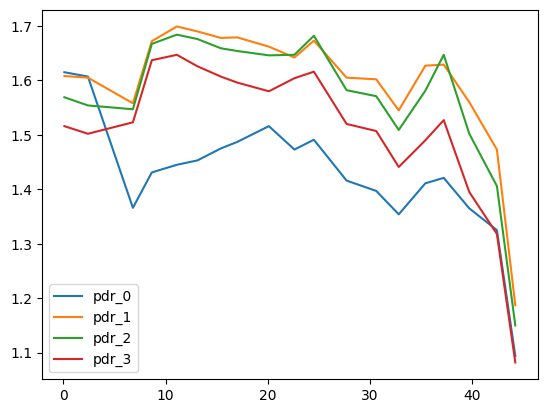

In [144]:
%matplotlib inline
xi =   [0.1,  2.4,  6.8,  8.65, 11.1, 13.1, 15.4, 17, 20.1, 22.6, 24.5 , 27.7, 30.6, 32.8, 35.4, 37.2, 39.7, 42.4, 44.2]
Qs =   [6.2,  6,  5.5,  5.3,  5.182,  4.82, 4.58, 4.45, 4.16, 3.8, 3.5, 3.1, 2.8, 2.45, 2.12, 1.8, 1.35, 0.74, 0.63]
snrs = [10.7, 10.2, 9.85, 9.64, 9.7, 9.4, 9.2, 9.16, 8.8, 8.5, 8.2, 7.8, 7.56, 7.0, 6.7, 6.27, 5.78, 5.0, 4.43]

pdr_0 = [1.615, 1.607, 1.366, 1.431, 1.445, 1.453, 1.475, 1.487, 1.516, 1.473, 1.491, 1.416, 1.397, 1.354, 1.411, 1.421, 1.365, 1.325, 1.094]
pdr_1 = [1.608, 1.605, 1.558, 1.672, 1.699, 1.690, 1.678, 1.679, 1.662, 1.642, 1.673, 1.605, 1.602, 1.545, 1.627, 1.629, 1.560, 1.473, 1.187]
pdr_2 = [1.569, 1.554, 1.547, 1.667, 1.684, 1.676, 1.659, 1.654, 1.646, 1.647, 1.682, 1.582, 1.571, 1.509, 1.581, 1.647, 1.502, 1.406, 1.150]
pdr_3 = [1.516, 1.502, 1.523, 1.637, 1.647, 1.626, 1.607, 1.596, 1.580, 1.604, 1.616, 1.520, 1.507, 1.441, 1.490, 1.527, 1.395, 1.318, 1.082]
msnr = [1.66, 1.65, 1.67, 1.843, 1.865, 1.844, 1.824, 1.816, 1.805, 1.860, 1.889, 1.782, 1.792, 1.816, 1.847, 1.882, 1.929, 2.008, 2.070]

plt.plot(xi, pdr_0, label='pdr_0')
plt.plot(xi, pdr_1, label='pdr_1')
plt.plot(xi, pdr_2, label='pdr_2')
plt.plot(xi, pdr_3, label='pdr_3')
plt.legend()


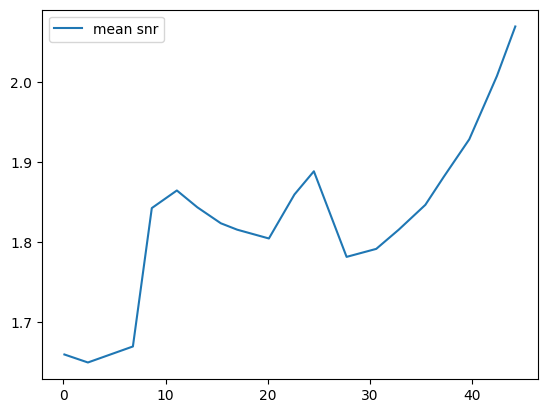

In [145]:
plt.plot(xi, msnr, label='mean snr')
plt.legend()

# Q Factor

### Q(ᵡ)

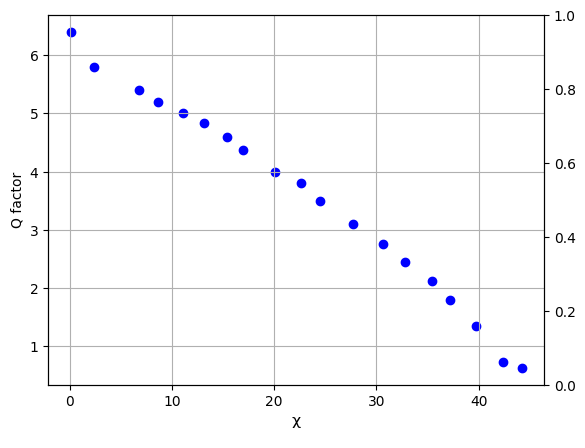

In [29]:
# %matplotlib notebook
%matplotlib inline
# gain 12
# xi = [0.37, 4.85, 6.46, 10.6, 14.68, 16.6, 17.3, 22.9, 24.4, 28.1, 30.4, 34.9, 37.2, 40.2, 42.7, 44.7]
# Qs = [5.8, 5.61, 5.26, 4.91, 4.51, 4.38, 4.11, 3.63, 3.4, 3.06, 2.75, 2.08, 1.7, 1.25, 0.73, 0.63]
# snrs = [10.480, 10.168, 9.871, 9.746, 9.235, 9.208, 9.079, 8.462, 8.177, 7.988, 7.441, 6.881, 6.256, 5.694, 4.977, 4.268]

# gain 24
xi =   [0.1,  2.4,  6.8,  8.65, 11.1, 13.1, 15.4, 17, 20.1, 22.6, 24.5 , 27.7, 30.6, 32.8, 35.4, 37.2, 39.7, 42.4, 44.2]
Qs =   [6.4,  5.8,  5.4,  5.2,  5.0,  4.84, 4.6, 4.38, 4, 3.8, 3.5, 3.1, 2.75, 2.45, 2.12, 1.8, 1.35, 0.74, 0.63]
snrs = [10.7, 10.2, 9.85, 9.64, 9.7, 9.4, 9.2, 9.16, 8.8, 8.5, 8.2, 7.8, 7.56, 7.0, 6.7, 6.27, 5.78, 5.0, 4.43]
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

ax1.scatter(xi, Qs, label='Q factor', color='b')
# ax2.scatter(xi, snrs, label='snr', color='g')


ax1.set_xlabel(f'ᵡ',  fontsize=18)
ax1.set_ylabel('Q factor')
# ax1.set_ylabel('Q factor', color='b')
# ax2.set_ylabel('SNR', color='g')

ax1.grid()


### Q(gain)

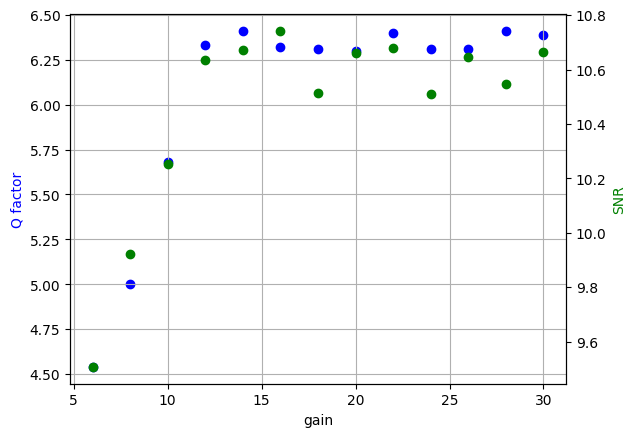

In [317]:
gain = [6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]
snrs = [9.507, 9.921, 10.252, 10.635, 10.671, 10.742, 10.512, 10.66, 10.678, 10.509, 10.646, 10.546, 10.664]
Qs = [4.54, 5.00, 5.68, 6.33, 6.41, 6.32, 6.31, 6.3, 6.4, 6.31, 6.31, 6.41, 6.39]

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

ax1.scatter(gain, Qs, label='Q factor', color='b')
ax2.scatter(gain, snrs, label='snr', color='g')


ax1.set_xlabel(f'gain')
ax1.set_ylabel('Q factor', color='b')
ax2.set_ylabel('SNR', color='g')

ax1.grid()


## SNR mean/std

In [6]:
weights_biases2xi = {
    44.7: (
        [-112.06, -21.5, -20.517, -20.663],
        [235.035, 10.882, 42.655, 41.047, 41.355]
    ),
    42.7: (
        [-84.471, -21.442, -20.521, -20.728],
        [185.918, 17.029, 42.551, 41.065, 41.493]
    ),
    40.2: (
        [-63.525, -21.398, -20.51, -20.777],
        [148.636, 21.698, 42.643, 41.087, 41.59]
    ),
    37.2: (
        [-49.822, -21.38, -20.543, -20.789],
        [124.205, 24.712, 42.563, 41.14, 41.622]
    ),
    34.9: (
        [-40.31, -21.337, -20.523, -20.797],
        [107.323, 26.916, 42.484, 41.135, 41.672]
    ),
    30.4: (
        [-26.073, -21.301, -20.504, -20.81],
        [81.819, 29.788, 42.529, 41.045, 41.629]
    ),
    28.1: (
        [-22.22, -20.797, -20.321, -20.808],
        [76.204, 31.873, 41.482, 40.693, 41.635]
    ),
    24.4: (
        [-18.599, -20.752, -20.18, -20.807],
        [70.1, 33.083, 41.376, 40.418, 41.663]
    ),
    22.5: (
        [-14.785, -22.158, -16.651, -20.806],
        [67.842, 38.242, 44.196, 33.457, 41.604]
    ),
    17.3: (
        [-9.895, -21.482, -20.347, -20.591],
        [53.799, 34.073, 42.899, 40.714, 41.206]
    ),
    16.6: (
        [-9.896, -21.483, -20.349, -20.591],
        [53.846, 34.091, 42.951, 40.759, 41.223]
    ),
    14.6: (
        [-8.455, -20.563, -20.377, -20.617],
        [52.97, 36.011, 41.175, 40.705, 41.209]
    ),
    10.6: (
        [-6.14, -21.395, -20.934, -20.772],
        [46.254, 34.107, 42.725, 41.864, 41.555]
    ),
    6.4: (
        [-4.069, -20.842, -20.888, -20.733],
        [43.763, 35.725, 41.621, 41.762, 41.459]
    ),
    4.8: (
        [-3.714, -20.503, -20.588, -20.714],
        [44.452, 37.039, 41.031, 41.144, 41.42]
    ),
    0.3: (
        [-2.115, -20.5, -20.671, -20.734],
        [41.551, 37.349, 41.039, 41.293, 41.442]
    ),
}

weights_biases2gain = {
    
    30: (
        [-55.846, -22.398, -20.981, -20.736],
        [144.443, 34.601, 44.045, 41.818, 41.572]
    ),
    28: (
        [-49.433, -22.607, -20.942, -20.746],
        [131.348, 34.212, 44.495, 41.778, 41.63]
    ),
    26: (
        [-46.201, -21.885, -20.879, -20.749],
        [126.38, 35.19, 43.321, 41.661, 41.55]
    ),
    24: (
        [-40.64, -22.062, -20.861, -20.715],
        [115.174, 34.986, 43.672, 41.664, 41.516]
    ),
    22: (
        [-35.345, -22.177, -20.798, -20.685],
        [104.673, 34.878, 43.997, 41.566, 41.441]
    ),
    20: (
        [-30.939, -21.917, -20.773, -20.675],
        [96.458, 35.272, 43.535, 41.524, 41.413]
    ),
    18: (
        [-26.038, -21.92, -20.743, -20.666],
        [86.795, 35.27, 43.614, 41.48, 41.386]
    ),
    16: (
        [-20.732, -22.177, -20.704, -20.641],
        [75.966, 34.983, 44.165, 41.403, 41.344]
    ),
    14: (
        [-14.609, -22.806, -20.675, -20.587],
        [63.071, 34.265, 45.439, 41.369, 41.219]
    ),
    12: (
        [-10.158, -22.582, -20.776, -20.563],
        [54.456, 34.417, 45.04, 41.563, 41.163]
    ),
    10: (
        [-10.144, -22.382, -20.593, -20.373],
        [54.628, 34.525, 44.752, 41.165, 40.752]
    ),
    8: (
        [-5.21, -19.883, -20.357, -20.237],
        [49.426, 38.938, 39.82, 40.694, 40.469]
    ),
    6: (
        [-0.749, -19.861, -20.532, -20.419],
        [39.253, 37.706, 39.807, 41.034, 40.802]
    ),
}

In [244]:
xis = []
Qs = []
mu_std_snrs = []
mirror_the_filter = False
for xi, (chosen_bias, chosen_weights) in weights_biases2xi.items():
# for xi, (chosen_bias, chosen_weights) in weights_biases2gain.items():
    xis.append(xi)
    res_resonator = simple_resonator(
        clk_freq=clk_freq,
        freq0=freq0,
        lf=lf,
        thetas=chosen_bias,
        weights=chosen_weights,
    )

    for i in range(len(res_resonator.neurons)):
        res_resonator.log_out_spikes(i)
    res_resonator.input_full_data(sine_wave)

    output = [events_to_spikes(neuron_output(neuron, freq0)-resonator_input[0],
                               run_window=spikes_window,
                               spikes_arr_size=int(clk_freq/freq0)+3)
              for neuron in res_resonator.neurons]

    x = np.linspace(0, 360, len(rresonator_input))
    xi = x[int(argmax(output[0]))] - x[int(argmax(rresonator_input))]
    
    from snn.resonator import test_resonator_on_chirp, freq_of_resonator
    clk_freq = 1_536_000
    res_resonator = simple_resonator(
        clk_freq=clk_freq,
        freq0=freq0,
        lf=lf,
        thetas=chosen_bias,
        weights=chosen_weights,
    )

    for nid in range(1, 5):
        res_resonator.log_out_spikes(nid)

    start_freq = 0
    spectrum = 2 * freq0
    res_resonator.forget_logs()

    step = 200/(clk_freq)
    test_size = int(spectrum / step)
    test_resonator_on_chirp(
        res_resonator,
        start_freq=start_freq,
        step=step,
        test_size=test_size,
        clk_freq=clk_freq
    )

    snr = [0] * 4
    pdr = [0] * 4
    peak = [0] * 4
    best_lp = lp_by_lf(lf, freq0, clk_freq)
    f_resonator = freq_of_resonator(clk_freq, lf, best_lp)
    for nid in range(4):
        spikes_neuron = res_resonator.neurons[nid + 1]
        y_events = spikes_neuron.out_spikes()
        y_spikes = np.zeros(test_size)
        y_spikes[y_events] = 1
        y_spikes = np.convolve(y_spikes, np.ones(spikes_window, dtype=int), 'valid')
        x = np.linspace(start_freq, start_freq+spectrum, len(y_spikes))

        snr[nid] = (y_spikes.max() - y_spikes.min())/y_spikes.std()
        std = y_spikes.std()
        p = y_spikes[((x > freq0 - 1*std) & (x < freq0 + 1*std))].max()
        n = y_spikes[((x < freq0 - 3*std) | (x > freq0 + 3*std))].max()

    nid = 3

    f0 = x[y_spikes == y_spikes.max()]
    f0 = (f0[0] + f0[-1])/2
    f2 = np.mean(y_spikes) + .5*(np.max(y_spikes) - np.mean(y_spikes))
    arg_Q = x[(y_spikes > f2*.997) & (y_spikes < f2*1.003)]
    Qs.append(f0/(arg_Q[-1] - arg_Q[0]))
    if mirror_the_filter:
        y_spikes = np.abs(y_spikes - y_spikes.mean())
    mu_std_snrs.append(p/n)


<IPython.core.display.Javascript object>


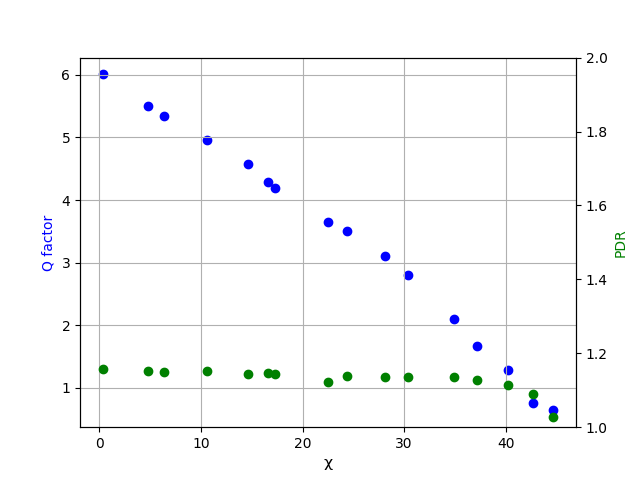

In [245]:
%matplotlib notebook
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

ax1.scatter(xis, Qs, label='Q factor', color='b')
ax2.scatter(xis, mu_std_snrs, label='snr', color='g')


ax1.set_xlabel(f'ᵡ',  fontsize=18)
# ax1.set_xlabel(f'Gain')
ax1.set_ylabel('Q factor', color='b')
ax2.set_ylabel('PDR', color='g')
ax2.set_ylim([1, 2])

ax1.grid()


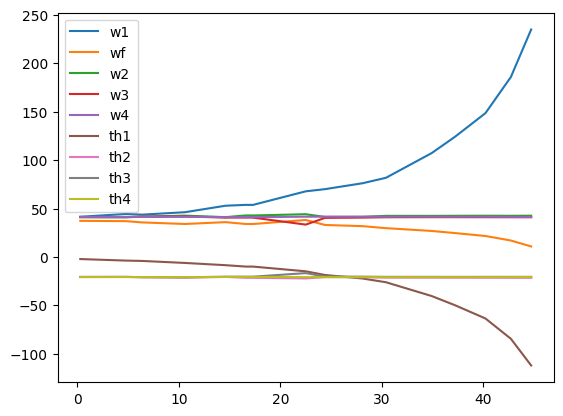

In [26]:
xis = []

w1 = []
wf = []
w2 = []
w3 = []
w4 = []

th1 = []
th2 = []
th3 = []
th4 = []

for xi, (thetas, weights) in list(weights_biases2xi.items())[::-1]:
    xis.append(xi)
    w1.append(weights[0])
    wf.append(weights[1])
    w2.append(weights[2])
    w3.append(weights[3])
    w4.append(weights[4])
    
    th1.append(thetas[0])
    th2.append(thetas[1])
    th3.append(thetas[2])
    th4.append(thetas[3])

    
w1 = np.array(w1)
wf = np.array(wf)
w2 = np.array(w2)
w3 = np.array(w3)
w4 = np.array(w4)

th1 = np.array(th1)
th2 = np.array(th2)
th3 = np.array(th3)
th4 = np.array(th4)

xis = np.array(xis)

plt.plot(xis, w1, label='w1')
plt.plot(xis, wf, label='wf')
plt.plot(xis, w2, label='w2')
plt.plot(xis, w3, label='w3')
plt.plot(xis, w4, label='w4')

plt.plot(xis, th1, label='th1')
plt.plot(xis, th2, label='th2')
plt.plot(xis, th3, label='th3')
plt.plot(xis, th4, label='th4')

plt.legend()

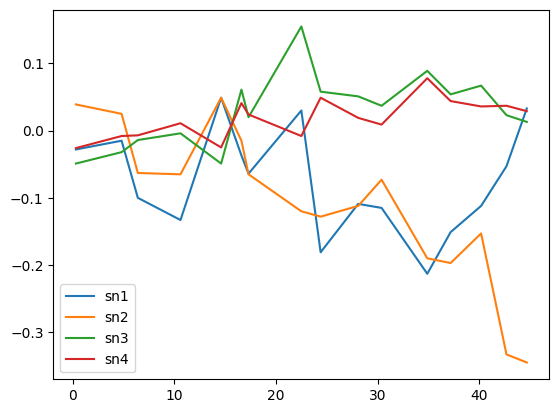

In [27]:
plt.plot(xis, (w1-wf) + 2*th1, label='sn1')
plt.plot(xis, w2 + 2*th2, label='sn2')
plt.plot(xis, w3 + 2*th3, label='sn3')
plt.plot(xis, w4 + 2*th4, label='sn4')
plt.legend()

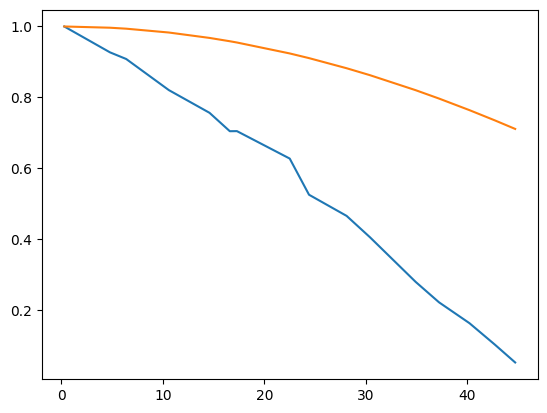

In [28]:
weights_ratio = []
for w_1, w_f in zip(w1, wf):
    weights_ratio.append(w1[0] * w_f / (w_1 * wf[0]))

plt.plot(xis, weights_ratio)
plt.plot(xis, np.cos(xis*np.pi/180))


## Weights as function of Xi

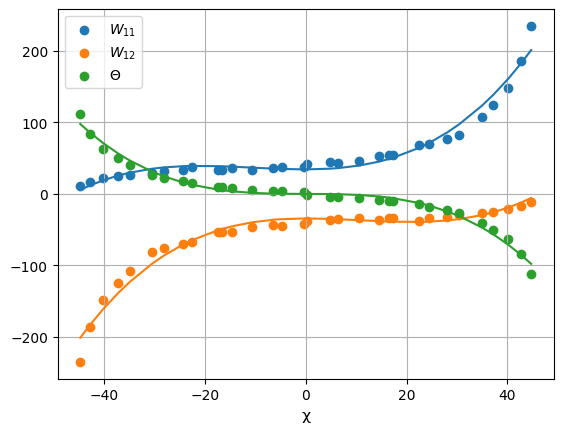

In [7]:
%matplotlib inline
from numpy.polynomial.polynomial import Polynomial

xis = np.array([44.7, 42.7, 40.2, 37.2, 34.9, 30.4, 28.1, 24.4, 22.5, 17.3, 16.6, 14.6, 10.6, 6.4, 4.8, 0.3])
thetas = np.array([
    [-112.06, -21.5, -20.517, -20.663],
    [-84.471, -21.442, -20.521, -20.728],
    [-63.525, -21.398, -20.51, -20.777],
    [-49.822, -21.38, -20.543, -20.789],
    [-40.31, -21.337, -20.523, -20.797],
    [-26.073, -21.301, -20.504, -20.81],
    [-22.22, -20.797, -20.321, -20.808],
    [-18.599, -20.752, -20.18, -20.807],
    [-14.785, -22.158, -16.651, -20.806],
    [-9.895, -21.482, -20.347, -20.591],
    [-9.896, -21.483, -20.349, -20.591],
    [-8.455, -20.563, -20.377, -20.617],
    [-6.14, -21.395, -20.934, -20.772],
    [-4.069, -20.842, -20.888, -20.733],
    [-3.714, -20.503, -20.588, -20.714],
    [-2.115, -20.5, -20.671, -20.734],
])
weights = np.array([
    [235.035, 10.882, 42.655, 41.047, 41.355],
    [185.918, 17.029, 42.551, 41.065, 41.493],
    [148.636, 21.698, 42.643, 41.087, 41.59],
    [124.205, 24.712, 42.563, 41.14, 41.622],
    [107.323, 26.916, 42.484, 41.135, 41.672],
    [81.819, 29.788, 42.529, 41.045, 41.629],
    [76.204, 31.873, 41.482, 40.693, 41.635],
    [70.1, 33.083, 41.376, 40.418, 41.663],
    [67.842, 38.242, 44.196, 33.457, 41.604],
    [53.799, 34.073, 42.899, 40.714, 41.206],
    [53.846, 34.091, 42.951, 40.759, 41.223],
    [52.97, 36.011, 41.175, 40.705, 41.209],
    [46.254, 34.107, 42.725, 41.864, 41.555],
    [43.763, 35.725, 41.621, 41.762, 41.459],
    [44.452, 37.039, 41.031, 41.144, 41.42],
    [41.551, 37.349, 41.039, 41.293, 41.442]
])

# w_diffs = weights[:, 0] - weights[:, 1]
# for i in range(2):
#     fit = Polynomial.fit(xis, weights[:, i], deg=15)
#     plt.scatter(xis, weights[:, i], label=f'weight {i}')
#     plt.plot(xis, fit(xis))
    

# for i in range(1):
#     fit = Polynomial.fit(xis, thetas[:, i], deg=15)
#     plt.scatter(xis, thetas[:, i], label=f'theta {i}')
#     plt.plot(xis, fit(xis))

xis = np.concatenate([-xis, xis[::-1]])
w0 = np.concatenate([weights[:, 1], weights[:, 0][::-1]])
w1 = np.concatenate([-weights[:, 0], -weights[:, 1][::-1]])
th = np.concatenate([-thetas[:, 0], thetas[:, 0][::-1]])


fit = Polynomial.fit(xis, w0, deg=3)
plt.scatter(xis, w0, label=r'$W_{11}$')
plt.plot(xis, fit(xis))

fit = Polynomial.fit(xis, w1, deg=3)
plt.scatter(xis, w1, label=r'$W_{12}$')
plt.plot(xis, fit(xis))

fit = Polynomial.fit(xis, th, deg=3)
plt.scatter(xis, th, label=r'$\Theta$')
plt.plot(xis, fit(xis))

plt.xlabel(f'ᵡ',  fontsize=18)
# plt.ylabel(f'')
plt.grid()
plt.legend()



In [137]:
xis

array([-44.7, -42.7, -40.2, -37.2, -34.9, -30.4, -28.1, -24.4, -22.5,
       -17.3, -16.6, -14.6, -10.6,  -6.4,  -4.8,  -0.3,  44.7,  42.7,
        40.2,  37.2,  34.9,  30.4,  28.1,  24.4,  22.5,  17.3,  16.6,
        14.6,  10.6,   6.4,   4.8,   0.3])

## Learn 1 neuron

In [62]:
def simple_neuron(
        freq0,
        clk_freq,
        lf,
        theta,
        weights,
):
    LF = lf
    LP = lp_by_lf(LF, freq0, clk_freq)
    network = SpikingNetwork(clk_freq)
    network.add_amplitude(1000)

    # Encode to pdm
    network.add_layer(SCTNLayer([create_SCTN() for _ in weights]))

    # SCTN 1
    neuron = create_SCTN()
    neuron.synapses_weights = np.array(weights, dtype=np.float64)
    neuron.leakage_factor = LF
    neuron.leakage_period = LP
    neuron.theta = theta
    neuron.activation_function = IDENTITY
    neuron.membrane_should_reset = False
    network.add_layer(SCTNLayer([neuron]))

    return network

def learning_neuron(
        freq0,
        clk_freq,
        lf,
        thetas,
        weights,
        ground_truth,
        A,
        time_to_learn,
        max_weight,
        min_weight,
):
    network = simple_neuron(freq0, clk_freq, lf, thetas, weights)
    tau = network.clk_freq * time_to_learn / 2
    network.neurons[1].set_supervised_stdp(A, tau, clk_freq, max_weight, min_weight, ground_truth)
    return network


In [90]:
# weights=[1458.303, 250.998], thetas=[-854.689]
# 46955it [1:36:00,  7.95it/s, weights=[0.0, 1459.998, 250.468], thetas=[0.0, -855.269], mse=1.15e+3, amplitudes=(333.0, 167.0), dc=261, tuned_parameters=1, xi=35.8]

resonator = learning_neuron(
    freq0=freq0,
    clk_freq=clk_freq,
    lf=lf,
    thetas=-855,
    weights=[1460, -251],
    ground_truth=ground_truth[0],
    A=2e-4,
    time_to_learn=1e-5,
    max_weight=np.inf,
    min_weight=-np.inf,
)
learning_rules = resonator.neurons[1].supervised_stdp
for i, neuron in enumerate(resonator.neurons):
    resonator.log_out_spikes(i)
    neuron.supervised_stdp = None

momentum_beta = .0

In [91]:
two_sine_wave = np.stack([sine_wave, sine_wave2], axis=1)
two_sine_wave.shape

(64365, 2)

<IPython.core.display.Javascript object>


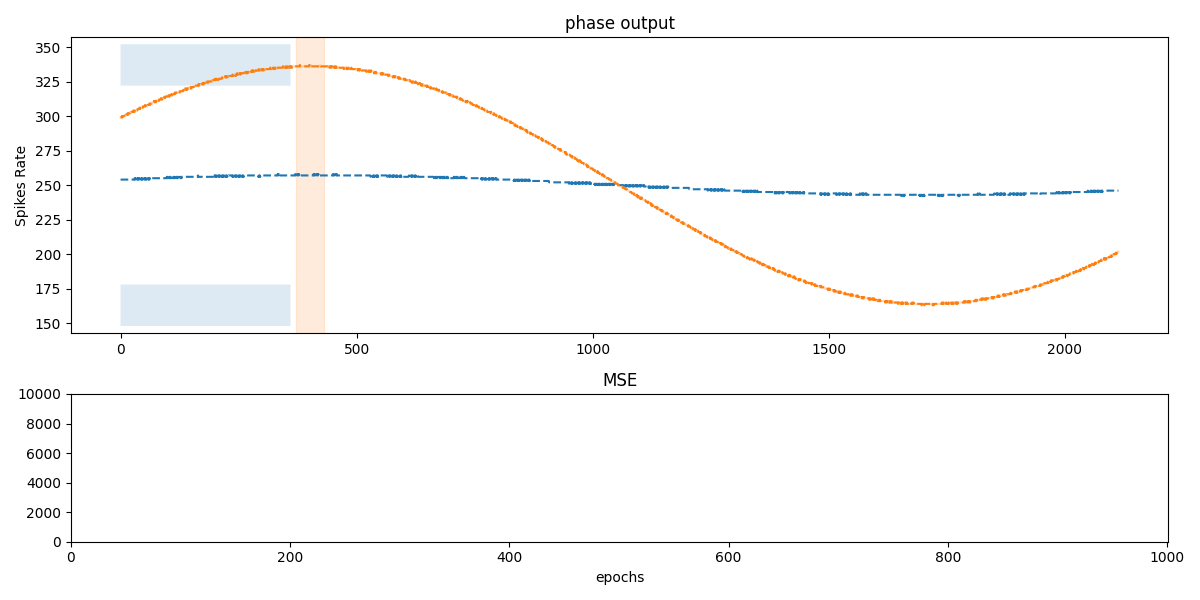

0it [00:00, ?it/s]


NameError: name 'two_sine_wave' is not defined

In [58]:
%matplotlib notebook
from tqdm import tqdm

from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# original colors
def_color = '#1f77b4'
colors = ['#ff7f0e']

# eeg colors
# colors = ['#50C9CE',  '#3B3561', '#EAD94C', '#51A3A3']
# def_color = '#F865B0'
epochs = 1000

phase_axs = 0
mse_axs = 1

mses = np.ones((epochs+1)) * np.inf
mses[0] = (rolling_gt[0]**2).mean()
min_mse = mses[0]

heights_ratios = np.ones(2)
heights_ratios[phase_axs] = 2
fig, axs = plt.subplots(2, 1, figsize=(12, 6), gridspec_kw={'height_ratios': heights_ratios})


y_epsilon = spikes_window * 0.03
x_epsilon = len(rresonator_input) * 5 / 360

gt_peak = argmax(rolling_gt[0])
x_phase = np.arange(0, len(rresonator_input))
axs[phase_axs].set_title('phase output')
axs[phase_axs].set_ylabel('Spikes Rate')
axs[phase_axs].set_ylim(gt_wave_amplitudes[0][1] - spikes_window * 0.04, gt_wave_amplitudes[0][0] + spikes_window * 0.04)
axs[phase_axs].fill_between(x_phase, gt_wave_amplitudes[0][0] - y_epsilon, gt_wave_amplitudes[0][0] + y_epsilon, facecolor=def_color, alpha=0.15)
axs[phase_axs].fill_between(x_phase, gt_wave_amplitudes[0][1] - y_epsilon, gt_wave_amplitudes[0][1] + y_epsilon, facecolor=def_color, alpha=0.15)

axs[phase_axs].plot(rresonator_input, label='input', color=def_color, linestyle='--')
phase_lines = axs[phase_axs].plot(rolling_gt[0], label=f'SN {0}', color=colors[0], linestyle='--')[0]
axs[phase_axs].plot(rolling_gt[0], color=colors[0], alpha=.3, label=f'GT {0}')[0]
axs[phase_axs].axvspan(gt_peak - x_epsilon, gt_peak + x_epsilon, alpha=0.15, color=colors[0])

axs[mse_axs].set_title('MSE')
axs[mse_axs].set_xlim(0, epochs+1)
axs[mse_axs].set_ylim(0, 10000)
axs[mse_axs].set_xlabel('epochs')
mse_lines = axs[mse_axs].plot([mses[0]], label=f'mse {0}', color=colors[0])[0]

fig.tight_layout()

momentum = 0
max_theta = -0.75
tuned_parameters = 0
count_after_tune = -1
with tqdm() as pbar:
    i = 1
    while count_after_tune != 0:
        count_after_tune -= 1
        run_with_stdp = True
        tuned_parameters = 0
        for neuron in resonator.neurons:
            neuron.membrane_potential = 0
            neuron.log_rand_gauss_var = 0
        resonator.forget_logs()
        resonator.input_full_data(two_sine_wave)

        # mse
        output = events_to_spikes(neuron_output(resonator.neurons[-1], freq0)-resonator_input[0],
                                   run_window=spikes_window,
                                   spikes_arr_size=int(clk_freq/freq0)+1)
        max_mse_y = 0
        mses[i] = ((rolling_gt[0] - output)**2).mean()
        if mses[i] < min_mse:
            min_mse = mses[i]
            run_with_stdp = False
        mse_lines.set_xdata(np.arange(i))
        mse_lines.set_ydata(mses[:i])
        max_mse_y = np.max([max_mse_y, 1.5*mses[max(0, i-4):i+1].max()])
            
        axs[mse_axs].set_ylim(0, max_mse_y)
#         axs[mse_axs].set_ylim(0, 2000)

        # phase chart
        phase_lines.set_ydata(output)

        thetas_shift = -.2*(((2*np.mean(output) - spikes_window)/spikes_window)**2)*np.sign(np.mean(output)-spikes_window/2)
        neuron = resonator.neurons[-1]
        bs = thetas_shift
        momentum = bs + momentum_beta * momentum
        neuron.theta += momentum
        if neuron.theta > max_theta:
            neuron.theta = max_theta

        peak = argmax(output)
        # activate weights learning
        dc = output.mean()
        o_max = output.max()
        o_min = output.min()
        neuron = resonator.neurons[-1]
        # first 2 conditions to check if the amplitude is on the right place.
        # next condition is to check if the peak is in the right place.
#         o_argmax = argmax(output)
        o_argmax = np.argmax(output)

        if (
#             abs(o_argmax - gt_peak) <= 2*x_epsilon and
            abs(o_max - gt_wave_amplitudes[0][0]) > y_epsilon/4 and
            abs(o_min - gt_wave_amplitudes[0][1]) > y_epsilon/4
           ):
            # 100 mse -> stretch_or_shrink_scale 0.001
            stretch_or_shrink_scale = (mses[i]*1000//1e4) / 1e4
            if gt_wave_amplitudes[0][1] < o_min < o_max < gt_wave_amplitudes[0][0]:
                neuron.theta -= stretch_or_shrink_scale
                neuron.synapses_weights[0] += 2 * stretch_or_shrink_scale #/ len(neuron.synapses_weights)
            elif o_min < gt_wave_amplitudes[0][1] < gt_wave_amplitudes[0][0] < o_max:
                stretch_or_shrink_scale *= 2
                neuron.theta += stretch_or_shrink_scale
                neuron.synapses_weights[0] -= 2 * stretch_or_shrink_scale #/ len(neuron.synapses_weights)
        if abs(o_argmax - gt_peak) <= x_epsilon:
            tuned_parameters += 1
        if (abs(o_max - gt_wave_amplitudes[0][0]) <= y_epsilon and
            abs(o_min - gt_wave_amplitudes[0][1]) <= y_epsilon
        ):
            tuned_parameters += 1
        if not run_with_stdp:
            neuron.supervised_stdp = None
        else:
            wave_amplitude = o_max - o_min
            gt_wave_amplitude = gt_wave_amplitudes[0][0] - gt_wave_amplitudes[0][1]
            wave_amplitude_ratio = abs((wave_amplitude - gt_wave_amplitude)/gt_wave_amplitude)        # number between 0 - 1 represent [0 - gt_wave_amplitude]
            phase_diff_ratio = abs(peak - gt_peak) / len(output)                                   # number between 0 - 1 represent [0 - 180]
            phase_diff_ratio = 10/180 + abs(peak - gt_peak) / len(output)                                   # number between 0 - 1 represent [0 - 180]
            neuron.supervised_stdp = learning_rules
            neuron.supervised_stdp.A = 10*(1 + wave_amplitude_ratio) * 10e-5
            neuron.supervised_stdp.tau = 1 * 1e-5 * clk_freq / 2 * (1 + phase_diff_ratio)

        wave_amplitudes = (output.max(), output.min())
        
        x = np.linspace(0, 360, len(rresonator_input))
#         xi = x[int(argmax(output))] - x[int(argmax(rresonator_input))]
        xi = x[int(np.argmax(output))] - x[int(argmax(rresonator_input))]
        pbar.set_postfix({'weights': flat_weights(resonator).tolist(), 'thetas': flat_thetas(resonator), 'mse': mses[i].mean(),
                          'amplitudes': wave_amplitudes, 'dc': output.mean(), 'tuned_parameters': tuned_parameters, 'xi': xi})

        for j in range(2):
            axs[j].legend(loc='upper right',  ncol=5 if j < 4 else 4)

        fig.canvas.draw()
        fig.canvas.flush_events()

        pbar.update(1)
        i += 1
        if i == epochs:
            min_mse = np.argmin(mses[:i-1])
            # min_mse = i-1
            print(f'min mse {mses[min_mse].mean()}')
            x = np.linspace(0, 360, len(rresonator_input))
            print(f'xi = {x[int(argmax(output))] - x[int(argmax(rresonator_input))]}')
            i = 1
            
        
        if tuned_parameters == 2 and count_after_tune < 0:
            count_after_tune = 100
            print('tune')
            print('weights', weights[i-1])
            print('thetas', biases[i-1])
            print('mse', mses[i-1])

# [axs[mse_axs].fill_between(np.arange(sns[0][0], i), 0, 1500, facecolor=c, alpha=0.15) for c, sns in zip(colors, areas_sns)] 

## Improve DC

In [ ]:
np.argmin(mses.mean(axis=1))

In [92]:
from snn.spiking_neuron import BINARY
import os
import json
from snn.resonator import test_resonator_on_chirp, freq_of_resonator

def trained_resonator(freq0, clk_freq, lf=4):
    configured_freq = freq0 * 1_536_000 / clk_freq
    root_folder = f'../filters{lf}/clk_1536000/parameters/'
    available_resonators = np.array([int(f[2:-5]) for f in os.listdir(root_folder)])
    arg_chosen_resonator = np.argmin(np.abs(available_resonators - configured_freq))
    chosen_resonator = available_resonators[arg_chosen_resonator]
    with open(f'{root_folder}/f_{chosen_resonator}.json') as f:
        parameters = json.load(f)
        thetas = parameters['thetas']
        weights = parameters['weights']
    return simple_resonator(freq0, clk_freq, 4, thetas, weights)

clk_freq = 1_536_00
freq0 = 13.5
resonator = trained_resonator(freq0, clk_freq)

neuron = create_SCTN()
neuron.synapses_weights = np.array([3.0])
neuron.leakage_period = np.inf
neuron.theta = -1
neuron.threshold_pulse = 3
neuron.reset_to = 1.5
neuron.activation_function = BINARY

resonator.add_layer(SCTNLayer([neuron]))

# 13.5 ~ peak 13.528 nid 3 snr 9.657


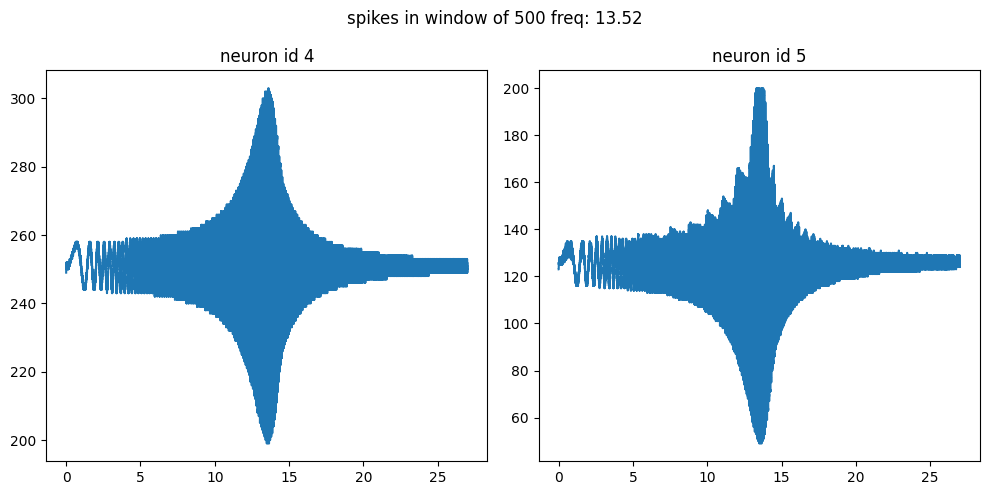

In [93]:
neuronds_id = [4, 5]
for nid in neuronds_id:
    resonator.log_out_spikes(nid)

start_freq = 0
spectrum = 2 * freq0
resonator.forget_logs()

step = 1/clk_freq
test_size = int(spectrum / step)
test_resonator_on_chirp(
    resonator,
    start_freq=start_freq,
    step=step,
    test_size=test_size,
    clk_freq=clk_freq
)

best_lp = lp_by_lf(lf, freq0, clk_freq)
f_resonator = freq_of_resonator(clk_freq, lf, best_lp)
fig, axs = plt.subplots(1, len(neuronds_id), figsize=(10, 5))
fig.suptitle(f'spikes in window of {spikes_window} freq: {f_resonator:.2f}')
for nid in neuronds_id:
    spikes_neuron = resonator.neurons[nid]
    y_events = spikes_neuron.out_spikes()
    y_spikes = np.zeros(test_size)
    y_spikes[y_events] = 1
    y_spikes = np.convolve(y_spikes, np.ones(spikes_window, dtype=int), 'valid')
    x = np.linspace(start_freq, start_freq+spectrum, len(y_spikes))

    ax = axs[nid - neuronds_id[0]]
    ax.plot(x, y_spikes)
    ax.set_title(f'neuron id {nid}')
fig.tight_layout()

nid = np.argmax(np.array(snr) / np.abs(np.array(peak) - freq0))
print(f'# {freq0} ~ peak {peak[nid]:.3f} nid {nid+1} snr {snr[nid]:.3f}')

0